# Maine

- Area : Humanities
- Start : jan-1996
- Finish : aug-2006
- Stationary : No
- m : 128

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error

sys.path.append("../utils/")
from data import load_dataset
from plot import plot, plot_stl, acf, plot_dist
from forecasting import Naive, SeasonalNaive, TimeSeriesForecaster
from metrics import pocid, multi_criteria

## Data

In [2]:
data = load_dataset(15)
period = 12
detrend = True

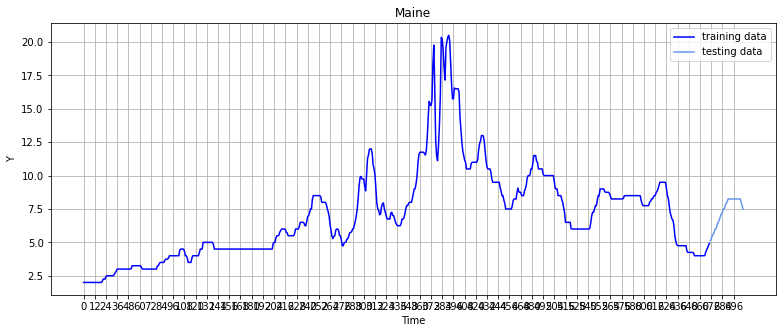

In [3]:
plot(data, 'Maine')

## STL decomposition

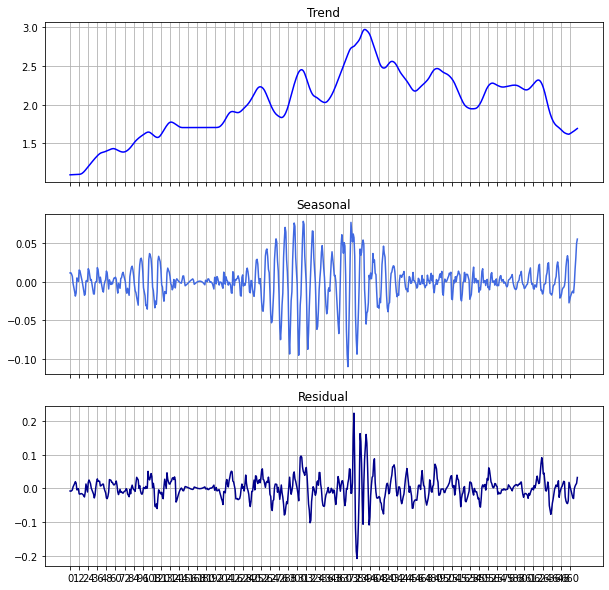

In [4]:
res = plot_stl(np.log1p(data[0]))

## Residual Diagnostics

In [5]:
acorr_ljungbox(res.resid, period=period, return_df=True)

,lb_stat,lb_pvalue
1,405.764120,3.063234e-90
2,504.641289,2.621419e-110
3,505.704749,2.769196e-109
4,524.242150,3.823132e-112
5,549.696841,1.486686e-116
6,558.720639,1.861073e-117
7,558.792751,1.809510e-116
8,565.281706,6.773428e-117
9,566.699793,2.921249e-116
10,576.706117,1.719452e-117


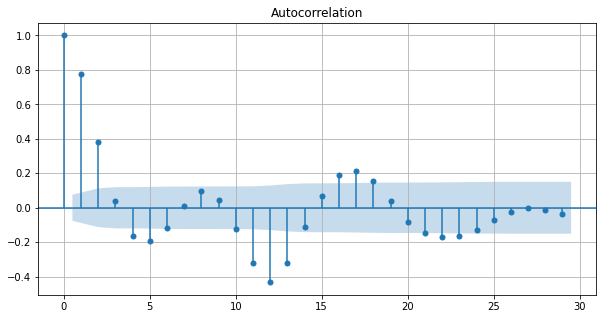

In [6]:
acf(res.resid)

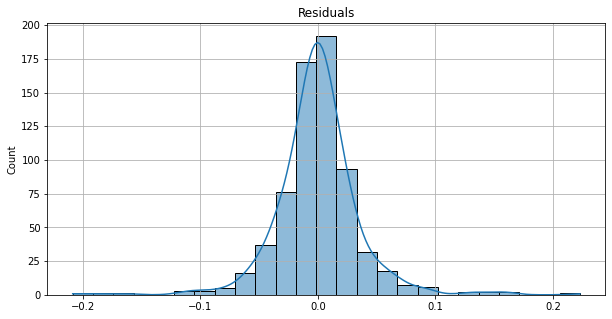

In [7]:
plot_dist(res.resid)

## Fitting and Forecasting

In [8]:
# Naive forecaster
naive = Naive()
naive.fit(data[0])
y_naive = naive.predict(len(data[1]))

# Seasonal Naive forecaster
snaive = SeasonalNaive(period=period)
snaive.fit(data[0])
y_snaive = snaive.predict(len(data[1]))

# Bayesian Ridge Regression
br = TimeSeriesForecaster(BayesianRidge(), window_length=period, detrend=detrend)
br.fit(data[0])
y_br = br.predict(len(data[1]))

# Hybrid Bayesian Ridge Regression
sbr = TimeSeriesForecaster(BayesianRidge(), window_length=period, detrend=detrend, period=period)
sbr.fit(data[0])
y_sbr = sbr.predict(len(data[1]))

# Kernel Ridge Regression
kr = TimeSeriesForecaster(KernelRidge(kernel="rbf"), window_length=period, detrend=detrend)
kr.fit(data[0])
y_kr = kr.predict(len(data[1]))

# Hybrid Kernel Ridge Regression
skr = TimeSeriesForecaster(KernelRidge(kernel="rbf"), window_length=period, detrend=detrend, period=period)
skr.fit(data[0])
y_skr = skr.predict(len(data[1]))

# Support Vector Machine
svr = TimeSeriesForecaster(LinearSVR(dual=False, loss="squared_epsilon_insensitive"), window_length=period, detrend=detrend)
svr.fit(data[0])
y_svr = svr.predict(len(data[1]))

# Hybrid Support Vector Machine
ssvr = TimeSeriesForecaster(
    LinearSVR(dual=False, loss="squared_epsilon_insensitive"), window_length=period, detrend=detrend, period=period)
ssvr.fit(data[0])
y_ssvr = ssvr.predict(len(data[1]))

# Kernel Support Vector Machine
ksvr = TimeSeriesForecaster(SVR(), window_length=period, detrend=detrend)
ksvr.fit(data[0])
y_ksvr = ksvr.predict(len(data[1]))

# Hybrid Kernel Support Vector Machine
sksvr = TimeSeriesForecaster(SVR(), window_length=period, detrend=detrend, period=period)
sksvr.fit(data[0])
y_sksvr = sksvr.predict(len(data[1]))

## Model Evaluation

In [9]:
maes = np.array([
    mean_absolute_error(data[1], y_br), mean_absolute_error(data[1], y_sbr), mean_absolute_error(data[1], y_kr),
    mean_absolute_error(data[1], y_skr), mean_absolute_error(data[1], y_svr), mean_absolute_error(data[1], y_ssvr),
    mean_absolute_error(data[1], y_ksvr), mean_absolute_error(data[1], y_sksvr)
])

pocids = np.array([
    pocid(data[1], y_br), pocid(data[1], y_sbr), pocid(data[1], y_kr), pocid(data[1], y_skr),
    pocid(data[1], y_svr), pocid(data[1], y_ssvr), pocid(data[1], y_ksvr), pocid(data[1], y_sksvr)
])

tu_naive = maes / mean_absolute_error(data[1], y_naive)
tu_snaive = maes / mean_absolute_error(data[1], y_snaive)

error_table = {
    "model" : [
        "Bayesian Ridge", "Seasonal Bayesian Ridge", "Kernel Ridge", "Seasonal Kernel Ridge",
        "SVR", "Seasonal SVR", "Kernel SVR", "Seasonal Kernel SVR"],
    "MAE" : maes,
    "TU-naive" : tu_naive,
    "TU-snaive" : tu_snaive,
    "POCID" : pocids
}

df = pd.DataFrame(error_table)
df = df.set_index("model")
df["MC"] = [multi_criteria(df.iloc[i,1:]) for i in range(len(df))]
df

,MAE,TU-naive,TU-snaive,POCID,MC
model,,,,,
Bayesian Ridge,1.735988,0.721075,0.561505,0.527778,0.437581
Seasonal Bayesian Ridge,1.869590,0.776569,0.604719,0.500000,0.502403
Kernel Ridge,2.319779,0.963564,0.750333,0.527778,0.663520
Seasonal Kernel Ridge,2.371458,0.985029,0.767048,0.500000,0.706505
SVR,1.867918,0.775875,0.604178,0.527778,0.485173
Seasonal SVR,2.258193,0.937983,0.730413,0.500000,0.657882
Kernel SVR,2.960982,1.229899,0.957730,0.111111,1.352069
Seasonal Kernel SVR,2.652788,1.101885,0.858045,0.500000,0.833736


In [10]:
print("Naive MAE: ", mean_absolute_error(data[1], y_naive))
print("SNaive MAE: ", mean_absolute_error(data[1], y_snaive))

Naive MAE:  2.4074999999999998
SNaive MAE:  3.0916666666666663
